In [20]:
import sys
import os.path
import statistics
from matplotlib import pyplot as plt
import pandas
from SciServer import CasJobs
import numpy as np
import mne

#BELOW is necessary since we are not currently running from project directory
#since we need to import libs from parent dir, need to add parent dir to path
project_path = '/home/idies/workspace/Storage/ncarey/persistent/PULSD/PsychoPy-pylsl-RSVP/'
if project_path not in sys.path:
    sys.path.append(project_path)

import importlib
EEGModels = importlib.import_module("arl-eegmodels.EEGModels")


In [21]:
session_ID=4

In [22]:
# Names for each channel
channel_names = ['F3', 'Fz', 'F4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Cp3', 'Cp4', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']

# The type (mag, grad, eeg, eog, misc, ...) of each channel
channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']

# The sampling rate of the recording
sfreq = 512  # in Hertz

# The EEG channels use the standard naming strategy.
# By supplying the 'montage' parameter, approximate locations
# will be added for them
montage = 'standard_1005'

# Initialize required fields
info = mne.create_info(channel_names, sfreq, channel_types, montage)

# Add some more information
info['description'] = 'test'
#info['bads'] = ['Pz']  # Names of bad channels

query = "select * from session_eeg where session_ID = {0} order by timestamp".format(session_ID)
df = CasJobs.executeQuery(sql=query, context="MyDB")

data = []
for index in range(len(channel_names)):
    data.append(df[channel_names[index]].values)

custom_raw = mne.io.RawArray(data, info)
print(custom_raw)

Creating RawArray with float64 data, n_channels=16, n_times=93856
    Range : 0 ... 93855 =      0.000 ...   183.311 secs
Ready.
<RawArray  |  None, n_channels x n_times : 16 x 93856 (183.3 sec), ~11.5 MB, data loaded>


In [23]:
stim_index_query = '''
with stim_timestamps_index(index_value, timestamp) as (
select count(*), stim_timestamps.timestamp from session_eeg, stim_timestamps 
where session_eeg.session_ID = {0} and stim_timestamps.session_ID = {0} and session_eeg.timestamp < stim_timestamps.timestamp 
group by stim_timestamps.timestamp
)

select stim_timestamps_index.index_value, stim_timestamps.stim_ID from stim_timestamps_index, stim_timestamps 
where stim_timestamps.session_ID = {0} and stim_timestamps.timestamp = stim_timestamps_index.timestamp
  order by stim_timestamps_index.index_value
'''.format(session_ID)

stim_index_df = CasJobs.executeQuery(sql=stim_index_query, context="MyDB")

In [24]:
stim_ind = stim_index_df['index_value'].values
stim_ID = stim_index_df['stim_ID'].values

events = []
for i in range(len(stim_ind)):
    events.append([stim_ind[i]+1, 0, stim_ID[i]])
    


In [25]:
event_id = dict(t_04=0, t_03=1, t_02=2, t_01=3, d_10=4, d_09=5, d_08=6, d_07=7, d_06=8, d_05=9, d_04=10, d_03=11, d_02=12, d_01=13)

epochs = mne.Epochs(raw=custom_raw, events=events, event_id=event_id, tmin=-.1, tmax=.6)

400 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


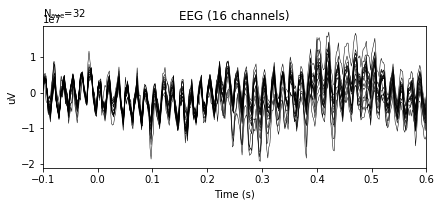

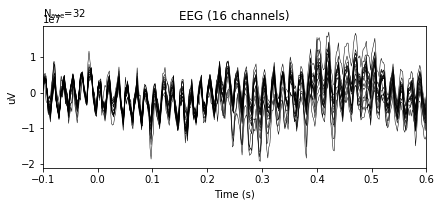

In [26]:
epochs['t_01', 't_02', 't_03', 't_04'].average().plot(time_unit='s')

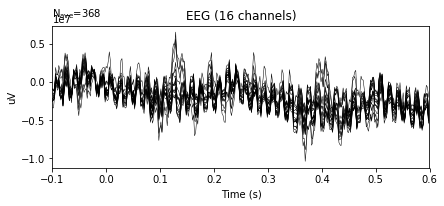

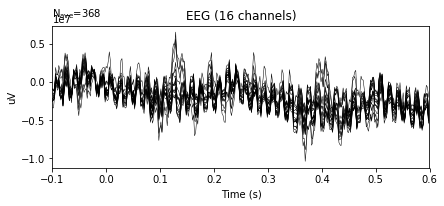

In [27]:
epochs['d_01', 'd_02', 'd_03', 'd_04', 'd_05', 'd_06', 'd_07', 'd_08', 'd_09', 'd_10'].average().plot(time_unit='s')

Loading data for 32 events and 359 original time points ...
0 bad epochs dropped
Original sampling rate: 512.0 Hz
New sampling rate: 100.0 Hz


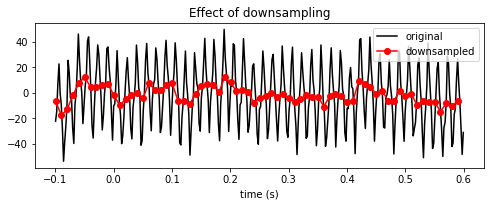

In [28]:
t_epochs = epochs['t_01', 't_02', 't_03', 't_04']
t_epochs.load_data()
# Downsample to 100 Hz
print('Original sampling rate:', epochs.info['sfreq'], 'Hz')
epochs_resampled = t_epochs.copy().resample(100, npad='auto')
print('New sampling rate:', epochs_resampled.info['sfreq'], 'Hz')

# Plot a piece of data to see the effects of downsampling
plt.figure(figsize=(7, 3))

n_samples_to_plot = int(1 * t_epochs.info['sfreq'])  # plot 0.5 seconds of data
plt.plot(t_epochs.times[:n_samples_to_plot],
         t_epochs.get_data()[0, 0, :n_samples_to_plot], color='black')

n_samples_to_plot = int(1 * epochs_resampled.info['sfreq'])
plt.plot(epochs_resampled.times[:n_samples_to_plot],
         epochs_resampled.get_data()[0, 0, :n_samples_to_plot],
         '-o', color='red')

plt.xlabel('time (s)')
plt.legend(['original', 'downsampled'], loc='best')
plt.title('Effect of downsampling')
mne.viz.tight_layout()

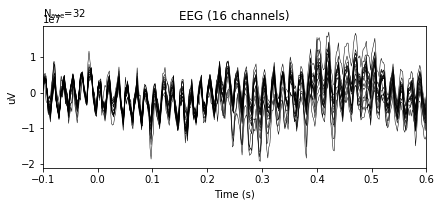

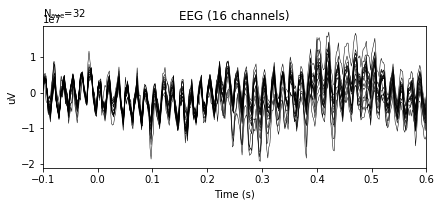

In [29]:
t_epochs.average().plot(time_unit='s')

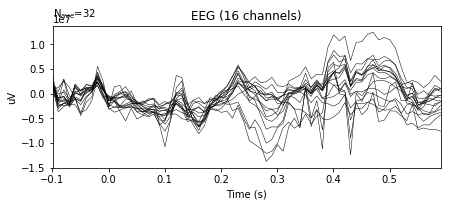

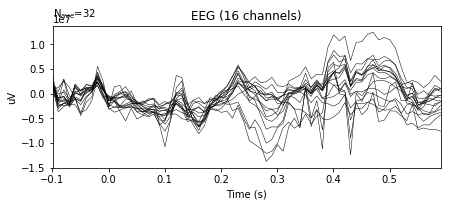

In [30]:
epochs_resampled.average().plot(time_unit='s')

Loading data for 368 events and 359 original time points ...
0 bad epochs dropped


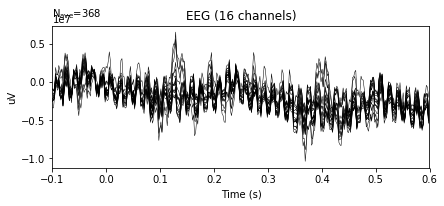

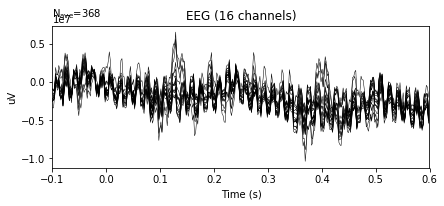

In [31]:
d_epochs = epochs['d_01', 'd_02', 'd_03', 'd_04', 'd_05', 'd_06', 'd_07', 'd_08', 'd_09', 'd_10']
d_epochs.load_data()
d_epochs_resampled = d_epochs.copy().resample(100, npad='auto')

d_epochs.average().plot(time_unit='s')

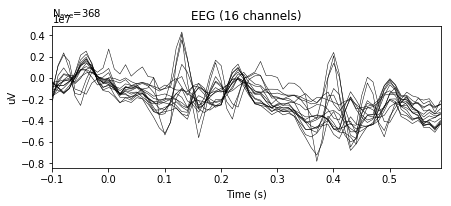

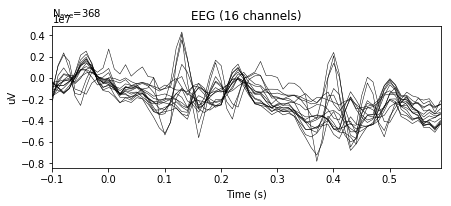

In [32]:
d_epochs_resampled.average().plot(time_unit='s')

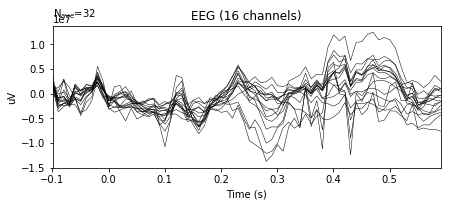

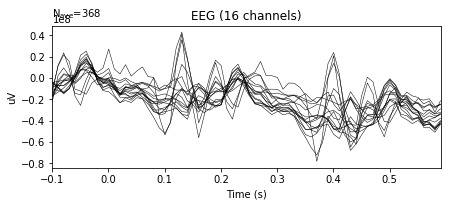

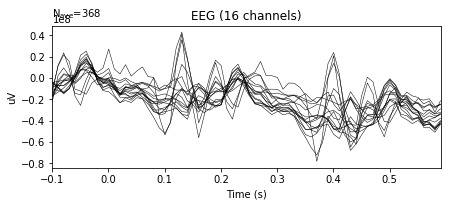

In [33]:
epochs_resampled.average().plot(time_unit='s')
d_epochs_resampled.average().plot(time_unit='s', scalings=dict(eeg=1e7))